In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
!pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import transformers
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


E0000 00:00:1722820684.085484      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0805 01:18:04.093787948      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0805 01:18:04.093802087      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0805 01:18:04.093805322      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0805 01:18:04.093807726      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0805 01:18:04.093810126      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:

# Load the data
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

In [6]:
# Merge and filter test data
merged_test_data = pd.merge(test_data, test_labels, on='id')
filtered_test_data = merged_test_data[(merged_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]


In [7]:
# Create 'is_toxic' label
filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

/tmp/ipykernel_13/269015839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


In [8]:
# Clean the comment text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [9]:
train_data['cleaned_comment'] = train_data['comment_text'].apply(clean_text)
filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)

/tmp/ipykernel_13/1713112218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)


In [11]:
# Load BERT tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
max_length = 128
X_train = tokenizer.batch_encode_plus(
    train_data['cleaned_comment'].tolist(),
    max_length=max_length,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

X_test = tokenizer.batch_encode_plus(
    filtered_test_data['cleaned_comment'].tolist(),
    max_length=max_length,
    padding=True,
    truncation=True,
    return_tensors='tf'
)


I0000 00:00:1722821049.126623      13 service.cc:145] XLA service 0x56898b3d6c00 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722821049.126693      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722821049.126697      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722821049.126700      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722821049.126703      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722821049.126706      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722821049.126708      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722821049.126711      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722821049.126714      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [13]:

y_train = train_data['is_toxic'].values
y_test = filtered_test_data['is_toxic'].values

In [14]:

# Initialize TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of accelerators:  8


In [17]:
# Load BERT model for sequence classification
from transformers import TFBertForSequenceClassification

with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Train the model
history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train,
    epochs=10,
    batch_size=16 * strategy.num_replicas_in_sync,  # Adjust batch size for TPU
    validation_split=0.1
)


Epoch 1/10


2024-08-05 01:35:44.386543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1722821747.064500     802 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6fde9ecfe12c04e2:0:0), session_name()
I0000 00:00:1722821779.390736     802 tpu_compile_op_common.cc:245] Compilation of 6fde9ecfe12c04e2:0:0 with session name  took 32.32619218s and succeeded
I0000 00:00:1722821779.497618     802 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6fde9ecfe12c04e2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1078402362833602345", property.function_library_fingerprint = 15407562398263477999, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

1122/1122 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9567

2024-08-05 01:38:27.681907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1722821908.376924     784 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a456b35f516f5455:0:0), session_name()
I0000 00:00:1722821913.184837     784 tpu_compile_op_common.cc:245] Compilation of a456b35f516f5455:0:0 with session name  took 4.807865438s and succeeded
I0000 00:00:1722821913.208755     784 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a456b35f516f5455:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_15521337700481110129", property.function_library_fingerprint = 12984409237997532151, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolo

1122/1122 [==============================] - 229s 126ms/step - loss: 0.1145 - accuracy: 0.9567 - val_loss: 0.0919 - val_accuracy: 0.9624
Epoch 2/10


I0000 00:00:1722821920.300647     770 tpu_compile_op_common.cc:245] Compilation of 7f940d9e7d52eed8:0:0 with session name  took 4.085130078s and succeeded
I0000 00:00:1722821920.322909     770 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7f940d9e7d52eed8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_15521337700481110129", property.function_library_fingerprint = 12984409237997532151, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,128,;11,128,;11,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722821920.322948     770 tpu_compilation_cache_interface.cc:541] After adding entry for key 7f940

1122/1122 [==============================] - 119s 106ms/step - loss: 0.0732 - accuracy: 0.9708 - val_loss: 0.0980 - val_accuracy: 0.9657
Epoch 3/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0509 - accuracy: 0.9800 - val_loss: 0.1061 - val_accuracy: 0.9657
Epoch 4/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0299 - accuracy: 0.9890 - val_loss: 0.1344 - val_accuracy: 0.9621
Epoch 5/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.1564 - val_accuracy: 0.9631
Epoch 6/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.1954 - val_accuracy: 0.9626
Epoch 7/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.1866 - val_accuracy: 0.9645
Epoch 8/10
1122/1122 [==============================] - 119s 106ms/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.188

2024-08-05 02:02:26.256425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1722823346.895746     823 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(5d2b58ff52c9c86a:0:0), session_name()


   8/2000 [..............................] - ETA: 32s   

I0000 00:00:1722823350.387567     823 tpu_compile_op_common.cc:245] Compilation of 5d2b58ff52c9c86a:0:0 with session name  took 3.491764222s and succeeded
I0000 00:00:1722823350.408673     823 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(5d2b58ff52c9c86a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_10139780756231778580", property.function_library_fingerprint = 17408698906883286341, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,128,;4,128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722823350.408721     823 tpu_compilation_cache_interface.cc:541] After adding entry for key 5d2b58ff

1996/2000 [============================>.] - ETA: 0s

I0000 00:00:1722823381.219344     760 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(110554b75a746fe9:0:0), session_name()


2000/2000 [==============================] - 47s 17ms/step


I0000 00:00:1722823384.282924     760 tpu_compile_op_common.cc:245] Compilation of 110554b75a746fe9:0:0 with session name  took 3.063548438s and succeeded
I0000 00:00:1722823384.308822     760 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(110554b75a746fe9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_10139780756231778580", property.function_library_fingerprint = 17408698906883286341, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,128,;2,128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722823384.308853     760 tpu_compilation_cache_interface.cc:541] After adding entry for key 110554b7

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     57735
           1       0.52      0.90      0.66      6243

    accuracy                           0.91     63978
   macro avg       0.75      0.91      0.80     63978
weighted avg       0.94      0.91      0.92     63978

AUC: 0.9514298518887789


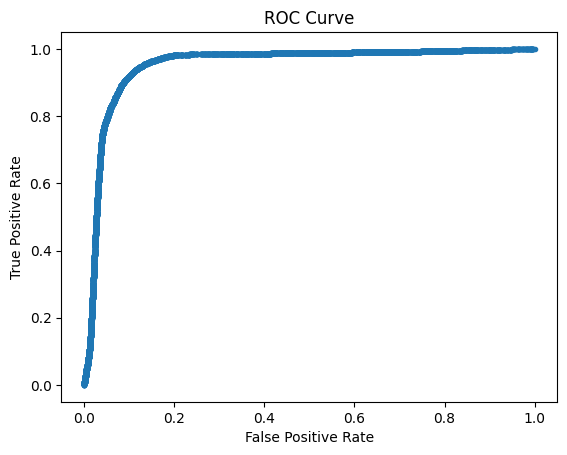

KS Statistic: 0.8224133055522576


In [19]:
# Evaluate the model
y_pred = model.predict([X_test['input_ids'], X_test['attention_mask']]).logits
y_pred_class = (y_pred > 0).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# KS statistic
ks_statistic = max(tpr - fpr)
print(f"KS Statistic: {ks_statistic}")

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from transformers import TFBertForSequenceClassification

# Initialize TPU strategy if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Load the model
with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Print the model summary
model.summary()

# Attempt to generate and save a model architecture diagram
try:
    model_keras = tf.keras.Model(inputs=model.input, outputs=model.output)
    plot_model(model_keras, to_file='bert_model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture diagram saved as 'bert_model_architecture.png'.")
except Exception as e:
    print(f"An error occurred: {e}")

# Extracting the model architecture details
model_summary = []
model_keras.summary(print_fn=lambda x: model_summary.append(x))

# Process the summary into a pandas DataFrame
summary_data = []

for layer in model_summary[1:]:  # Skip the first line as it's just the table header
    layer_details = layer.split()
    layer_name = layer_details[0]
    layer_type = layer_details[1]
    output_shape = ' '.join(layer_details[2:-2])  # The output shape may span multiple elements
    num_params = layer_details[-2]
    summary_data.append([layer_name, layer_type, output_shape, num_params])

summary_df = pd.DataFrame(summary_data, columns=["Layer Name", "Layer Type", "Output Shape", "Number of Parameters"])

# Display the DataFrame
print(summary_df)

# Save the DataFrame to a CSV file
summary_df.to_csv('bert_model_architecture.csv', index=False)
